# Анализ гипотез для увеличения выручки интернет-магазина

**Описание проекта**  
Отдел маркетинга совместно с бизнес-аналитиком крупного интернет-магазина подготовили список гипотез для увеличения выручки.


Имеется файл с 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. После проведения A/B-тест получили результаты, которые описали в файлах /datasets/orders.csv и /datasets/visitors.csv.

Данные для первой части   
Файл /datasets/hypothesis.csv.    
Hypothesis — краткое описание гипотезы;   
Reach — охват пользователей по 10-балльной шкале;   
Impact — влияние на пользователей по 10-балльной шкале;   
Confidence — уверенность в гипотезе по 10-балльной шкале;   
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.   



Данные для второй части   
Файл /datasets/orders.csv.    
transactionId — идентификатор заказа;   
visitorId — идентификатор пользователя, совершившего заказ;   
date — дата, когда был совершён заказ;   
revenue — выручка заказа;   
group — группа A/B-теста, в которую попал заказ.   



Файл /datasets/visitors.csv.    
date — дата;   
group — группа A/B-теста;   
visitors — количество пользователей в указанную дату в указанной группе A/B-теста   

 
Цель исследования: помочь компании увеличить выручку на основании анализа выдвинутых гипотез.

План исследования: 
1. Приоритезация гипотез 
2. Анализ А/В теста
3. Принятие решения о продолжении теста

### Загрузка данных
На первом этапе добавляем библиотеки

In [1]:
import pandas as pd
import datetime as dt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

Считаем CSV-файлы с данными с помощью библиотеки pandas,сохраним их в датафреймы. Выведем и изучим общую информацию о датафреймах.

In [2]:
visitors = pd.read_csv('/datasets/visitors.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors.info()
display(visitors)
orders.info()
display(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Изменим тип данных дат

In [3]:
orders['date'] = orders['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].astype('datetime64[D]')

**Вывод:** 
Пропущенных значений в датафреймах нет, был изменен тип данных у столбцов с датами. 

In [4]:
# посмотрим на число уникальных пользователей в каждой из групп:
print('Количество пользователей в группе А:', orders[orders['group']=='A']['visitorId'].nunique())
print('Количество пользователей в группе B:', orders[orders['group']=='B']['visitorId'].nunique())
print('Общее число пользователей:', orders ['visitorId'].nunique())

Количество пользователей в группе А: 503
Количество пользователей в группе B: 586
Общее число пользователей: 1031


In [5]:
#выведем количество пользователей, которые попали в обе группы :

len (np.intersect1d([orders[orders['group']=='A']['visitorId'].unique()],[orders[orders['group']=='B']['visitorId'].unique()]))
 

58

**Вывод:** ВВ группе В на 83 человека больше, чем в группе А.Есть 58 пользователей, попавших и в одну, и в другую группу, однако это представляется допустимым, поскольку это менее 5% от общего числа пользователей.

### Приоритизация гипотез

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [6]:
data = pd.read_csv('/datasets/hypothesis.csv', sep=',')
data['ICE'] = (data['Impact'] * data['Confidence'])/data['Efforts']
print(data[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False));

                                          Hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [7]:
data = pd.read_csv('/datasets/hypothesis.csv', sep=',')
data['RICE'] = (data['Reach']*data['Impact'] * data['Confidence'])/data['Efforts']
print(data[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False));

                                          Hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


**Вывод:** 
При приоритизации гипотез с помощью фреймворка ICE было установлено, что наибольшие значения имеют 3 гипотезы: 
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.



   При приоритизации гипотез с помощью фреймворка RICE было установлено, что наибольшие значения имеют 4 гипотезы: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.


При расчете RICE учитывается компонента Reach (скольких пользователей затронет изменение, которое вы хотите внести), это повлияло на приоритизацию гипотез. Так у гипотезы №7 самый высокий показатель Reach = 10.

Наименьшие значения при приоритизации гипотез с помощью фреймворков ICE и RICE имеют 4 гипотезы:
- Запустить собственную службу доставки, что сократит срок доставки заказов
- Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
- Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
- Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей.





### Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv. Проведем анализ A/B-теста.

#### Построим график кумулятивной выручки по группам

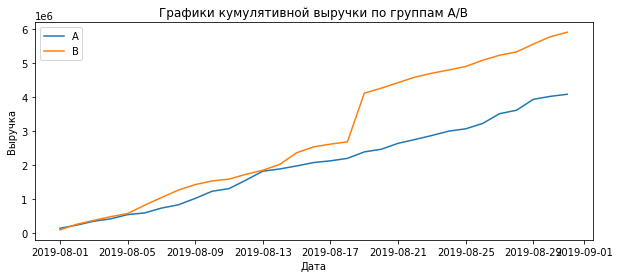

In [8]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

plt.figure(figsize=(10,4))
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Графики кумулятивной выручки по группам A/B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend()
plt.show(); 

**Вывод:**  Весь тест лидирует группа В. После прохождения середины теста наблюдается резкий скачок группы В.  Похоже, что аномально большие заказы всё-таки влияют на результаты. 

#### Построим график кумулятивного среднего чека по группам

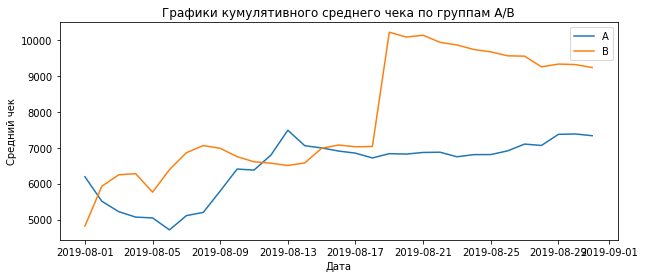

In [9]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show();

**Вывод:** Кумулятивное значение среднего чека в целом повторяет тенденцию, которая прослеживалась на графике кумулятивной выручки по группам. За тем исключением, что в начале и примерно до наступления середины теста средний чек группы А непродолжительное время превышал значения среднего чека группы В. И опять резкий рост среднего чека группы В после прохождения середины теста вызывает подозрения о наличии аномалий.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

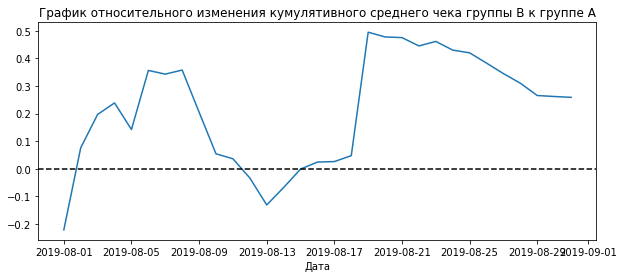

In [10]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,4))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 
plt.show();

**Вывод:** Результаты теста значительно и резко менялись в несколько дат. Видимо, именно тогда были совершены аномальные заказы. 

#### Построим график кумулятивного среднего количества заказов на посетителя по группам

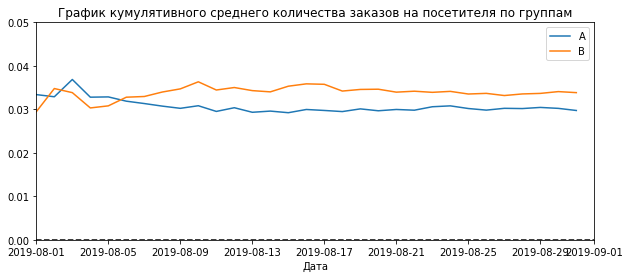

In [11]:
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(10,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);

**Вывод:** В начале теста группа А непродолжительное время имела большее кумулятивное среднее число заказов, но затем лидерство перешло к группе В.

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

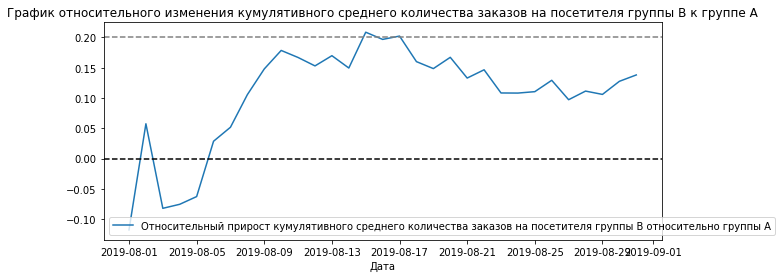

In [12]:
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.legend();

**Вывод:** Почти все время группа В лидирует, в середине теста зафиксирован прирост в 20% относительно группы А. 

#### Построим точечный график количества заказов по пользователям

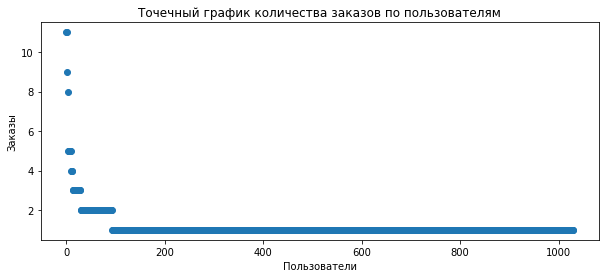

In [13]:
ordersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending = False)
ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Заказы')
plt.xlabel('Пользователи')
plt.show()

**Вывод:** В основном пользователи делали по 1 заказу. Совсем мало пользователей, который делали больше 2 заказов, возможно это аномалии.

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [14]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


**Вывод:** Не более 5% пользователей совершали больше 2 заказов, и не более 1% пользователей - больше 4 заказов. 

#### Построим точечный график стоимостей заказов

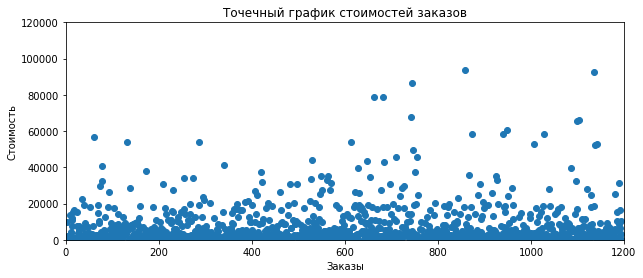

In [15]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость')
plt.xlabel('Заказы')
plt.axis([0, 1200, 0, 120000])
plt.show()

**Вывод:** Заказов стоимостью больше 30 тыс. руб.  мало. Есть выбросы в районе 90 тыс. руб.

#### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [16]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


**Вывод:** Не более 5% заказов больше 28 тыс. руб., и не более 1% заказов стоимостью 58 тыс. руб.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [17]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
print(data.head(5))
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 


        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

**Вывод:** P-value меньше 0,05, поэтому делаем вывод о существенности статистической значимости различий в среднем количестве заказов на посетителя. Относительный прирост среднего группы В к конверсии группы А равен 13,8%.

#### Посчитаем статистическую значимость различий в  среднем чеке заказа между группами по «сырым» данным

In [18]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


**Вывод:** P-value больше 0,05, значит статистической значимости различий в среднем чеке заказа между группами нет. Наблюдаемое относительное различие среднего чека между группами составляет 25,9% и не является статитстически значимым.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [19]:

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 10000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.00896
0.205


**Вывод:** Как и в случае с сырыми данными статистическая значимость достигнута. Группа В значительно лучше группы А.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [20]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.965
0.002


**Вывод:** Статистической значимости различия среднего чека заказов между группами нет.

#### Решение по результатам теста

По результатам проведенного исследования можем сделать следующие выводы:
1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
2. По сырым данным нет статистически значимого различия по среднему чеку между группами. Нет его и после удаления аномалий.
3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.
Исходя из вышеизложенного делаем вывод, что можно остановить тест изафиксировать победу группы В.

